# Wasserstein generative adversarial networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
PATH = "data/"
file_name = PATH + "mnist_train.csv"

In [3]:
df = pd.read_csv(file_name)

In [4]:
X = df.iloc[:, 1:].values
X = X.astype("float32")
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X = X.reshape((len(X), 1, 28, 28))
X.shape

(60000, 1, 28, 28)

In [5]:
batch_size = 128
seed = 42
device = "cuda"

In [6]:
class MnistDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).float().to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx, :, :, :]

In [7]:
class BatchConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=0):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, padding=padding,
                                       kernel_size=kernel_size, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.conv_1 = BatchConvTranspose(z_dim, int(z_dim / 2))
        self.conv_2 = BatchConvTranspose(int(z_dim / 2), int(z_dim / 4))
        self.conv_3 = BatchConvTranspose(int(z_dim / 4), int(z_dim / 8))
        
        self.conv_4 = nn.ConvTranspose2d(int(z_dim / 8), 1, padding=2, kernel_size=4, stride=2)
        self.act = nn.Tanh()
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.act(x)
        return x

In [8]:
class BatchConv(nn.Module):
    def __init__(self, in_channels, out_channels, padding=0, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding,
                              kernel_size=kernel_size, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = BatchConv(1, 16)
        self.conv_2 = BatchConv(16, 32)
        self.conv_3 = BatchConv(32, 64)
        self.output_conv = nn.Conv2d(64, 1, kernel_size=2, stride=1)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.output_conv(x)
        x = x.view((len(x), -1))
        return x

In [9]:
dataset = MnistDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)

In [10]:
z_dim = 128


torch.manual_seed(seed)
g_model = Generator(z_dim).to(device)
d_model = Discriminator().to(device)

In [11]:
lr = 1e-4
clamp_val = 0.01
n_critic = 5
epochs = 200

generator_optimizer = optim.RMSprop(g_model.parameters(), lr=lr)
discriminator_optimizer = optim.RMSprop(d_model.parameters(), lr=lr)

In [12]:
def set_trainable(model, trainable=True):
    for param in model.parameters():
        param.requires_grad = trainable

def clamp_model(model, c):
    for param in model.parameters():
        param.data.clamp_(-c, c)

In [13]:
d_loss_list = []

np.random.seed(seed)
torch.manual_seed(seed)
g_model.train()
d_model.train()

for epoch in range(epochs):
    epoch_d_loss = 0.0
    enum = enumerate(dataloader)
    
    for idx in range(len(dataloader) // n_critic):
        set_trainable(d_model, trainable=True)
        set_trainable(g_model, trainable=False)
        
        d_loss_iter = 0.0
        for n in range(n_critic):
            d_model.zero_grad()
            
            _, x = next(enum)
            z = torch.randn((len(x), z_dim, 1, 1), device=device)
            
            d_loss = d_model(x).mean() - d_model(g_model(z)).mean()
            d_loss.backward()
            discriminator_optimizer.step()
            d_loss_iter += d_loss.detach().cpu().numpy()
            
            clamp_model(d_model, clamp_val)
        epoch_d_loss += d_loss_iter / n_critic
        
        set_trainable(d_model, trainable=False)
        set_trainable(g_model, trainable=True)
        g_model.zero_grad()
        
        z = torch.randn((len(x), z_dim, 1, 1), device=device)
        g_loss = d_model(g_model(z)).mean()
        
        g_loss.backward()
        generator_optimizer.step()
        
    d_loss_list.append(-epoch_d_loss)
    
    if epoch % 10 == 0:
        print(f"------ Epoch {epoch} ------")
        print(f"Wasserstein distance: {-epoch_d_loss}")

------ Epoch 0 ------
Wasserstein distance: 0.6925728462636471
------ Epoch 10 ------
Wasserstein distance: 0.6822053190320729
------ Epoch 20 ------
Wasserstein distance: 0.3142017079051584
------ Epoch 30 ------
Wasserstein distance: 0.2054414832848125
------ Epoch 40 ------
Wasserstein distance: 0.17353619679342952
------ Epoch 50 ------
Wasserstein distance: 0.15686112714465714
------ Epoch 60 ------
Wasserstein distance: 0.144789439230226
------ Epoch 70 ------
Wasserstein distance: 0.12578962047118694
------ Epoch 80 ------
Wasserstein distance: 0.1136676350608468
------ Epoch 90 ------
Wasserstein distance: 0.10610491946572442
------ Epoch 100 ------
Wasserstein distance: 0.09617930093081663
------ Epoch 110 ------
Wasserstein distance: 0.09026577224285572
------ Epoch 120 ------
Wasserstein distance: 0.08419131136324723
------ Epoch 130 ------
Wasserstein distance: 0.08213923308067024
------ Epoch 140 ------
Wasserstein distance: 0.0768564177036751
------ Epoch 150 ------
Wasse

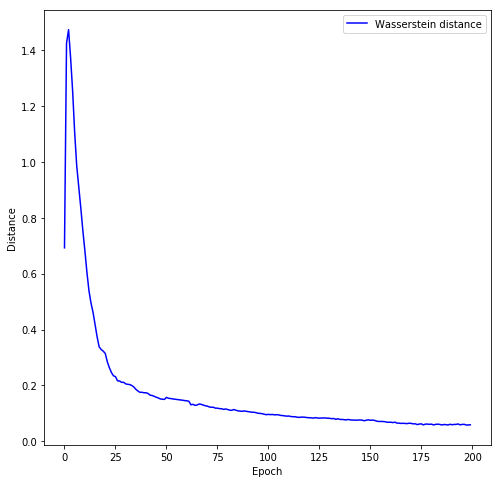

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(d_loss_list, "b", label="Wasserstein distance")
plt.xlabel("Epoch")
plt.ylabel("Distance")
plt.legend()
plt.show()

In [15]:
np.random.seed(seed)
g_model.eval()

z = np.random.normal(0, 1, size=(9, z_dim, 1, 1))
z = np.clip(z, -1, 1)
z = torch.from_numpy(z).float().to(device)
img_fake = g_model(z)
img_fake = img_fake[:, 0, :, :].detach().cpu().numpy()

img_fake = (img_fake + 1) * 255 / 2
img_fake = np.round(img_fake)

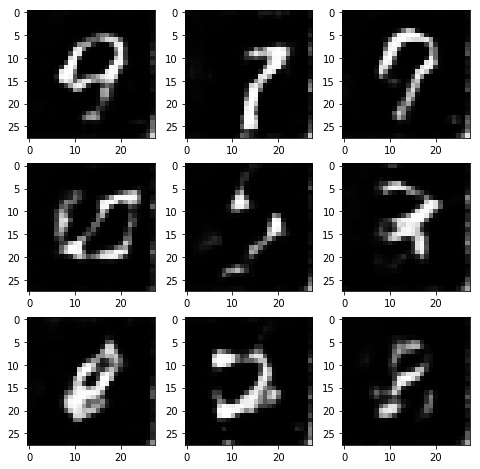

In [16]:
# Fake images
fig, ax = plt.subplots(3, 3, figsize=(8, 8))

for i in range(3):
    for j in range(3):
        ax[i, j].imshow(img_fake[i*3 + j, :, :], cmap="gray")
plt.show()

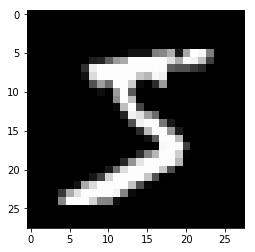

In [17]:
# Real image
plt.imshow(X[0, :].reshape(28, 28), cmap="gray")
plt.show()